# Facial Recogntion using PCA and LDA
---
Images were downloaded from http://www-prima.inrialpes.fr/perso/Gourier/Faces/HPDatabase.htmlw and requires the following citation: 

N. Gourier, D. Hall, J. L. Crowley
Estimating Face Orientation from Robust Detection of Salient Facial Features
Proceedings of Pointing 2004, ICPR, International Workshop on Visual Observation of Deictic Gestures, Cambridge, UK

Some of my helper functions for this paper, with inline documentation:

In [1]:
import numpy as np
import scipy as sc
from skimage import io
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter
%matplotlib inline

def findClosestPoint(p, M):
    """
    Given a point p and a set of points M, finds the closest point in that set
    to the given point.
    
    Parameters
    ----------
    p : float
        k-dimensional point that represents a test image.
        
    M : float
        Set of vectors to compare p against to find closest point.

    Returns
    -------
    index : int
        The row for the closest vector to p.

    """
    row, _ = M.shape
    min = np.linalg.norm(p - M[0])
    index = 0
    for i in range(1, row):
        if np.linalg.norm(p - M[i]) < min:
            min = np.linalg.norm(p - M[i])
            index = i
    return index

def findImage(image, pca_matrix, lda_matrix, lda_stacked):
    image_f = resize(image, (144, 192)).flatten()
    image_p = image_f.dot(pca_matrix)
    image_lda = image_p.dot(lda_matrix)
    index = findClosestPoint(image_lda, lda_stacked)
    Person = index // N
    Pose = index % N
    showSubplot(image, "Test Image", io.imread("TrainingImages\Person0" + str(Person + 1) + 
                                           "\person0" + str(Person + 1) + "146+0+0.jpg"), "Predicted Person")
    print("Person: " + str(Person))
    print("Pose: " + str(Pose))
    
def energy(X, s, k):
    """
    Computes the energy given k dimensions
    
    Parameters
    ----------
    X : float
        Set of vectors representing sample data.
        
    s : float
        Singular values for eigendecomposition of X.
        
    k : int
        Number of dimensions used.

    Returns
    -------
    float
        The amount of variance captured using k dimensions.

    """
    return np.square(s[:k + 1]).sum() / np.square(np.linalg.norm(X))
    
def ComputeER(X, s, mew):
    
    """
    Compute the number of dimensions needed to attain mew% of the variance
    
    Parameters
    ----------
    X : float
        Set of vectors representing sample data.
    s : float
        Set of singular values for the eigendecomposition of X.
    mew : float
        Percent of variance to be retained.

    Returns
    -------
    i : integer
        Number of dimensions needed to attain mew% of the variance
    energy_ : float
        Percentage of the variance retained.

    """
    for i in range(0, 128*128):
        energy_ = energy(X, s, i)
        if energy_ > mew:
            return i, energy_
        
def showSubplot(img1, t1, img2, t2):
    """
    Displays two images side by side

    Parameters
    ----------
    img1 : float
        An images represented as a vector.
    t1 : string
        Title for first image.
    img2 : float
        An image represented as a vector.
    t2 : string
        Title for second image

    Returns
    -------
    None.

    """
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(t1)
    plt.imshow(img1, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title(t2)
    plt.imshow(img2)
    
    plt.show()
    
def readClassData(strClass):
    """
    Reads in the sample for a class and stacks the vectors into a matrix

    Parameters
    ----------
    strClass : string
        String containing relative file path

    Returns
    -------
    c : stacked matrix

    """
    c = np.array([]) #class matrix
    directory = os.fsencode(strClass)

    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".jpg"):
            if(c.size == 0): #handles storing first image
                c = resize(io.imread(str(strClass) + str(filename),
                                     as_gray=True), (144, 192)).flatten()
            else:
                c = np.vstack([c, resize(io.imread(str(strClass) + 
                                                  str(filename), as_gray=True), (144, 192)).flatten()])
    return c

## Introduction

This project is meant to show the implementation of [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) and [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis), and their application to facial recognition. The algorithm is done in a few steps, which we will detail soon:
1. Read in training images for each class (face) as grayscale and store each image as a vector, where the 2-d image is converted to a 1-d vector by appending each row to the previous. 
2. Stack all the image vectors into a matrix $X$ 
3. Compute the PCA transformation matrix $P = \texttt{PCA}(X)$
4. Project our sample data $X$ onto this new subspace to get $X_{pca} = X \times P $
5. Compute the LDA transformation matrix $L = \texttt{LDA}(X_{pca})$
6. Project the PCA data onto this new subspace to get $X_{lda} = X_{pca} \times L $
7. $X_{lda}$ is our sample data with reduced dimensionality

## Principal Component Analysis (PCA)

PCA is an algorithm used for reducing the dimensionality of data by projecting it onto a lower-dimensional subspace that captures most of the variance in the data. The resulting dimensionality reduction can be drastic and allows us to do computations much more quickly.

### Algorithm:
1. Compute the [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) of $X: \textbf{e}, \textbf{λ} = \texttt{SVD}(X)$ where $\textbf{e}$ is the set of [eigenvectors](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors), sorted by decreasing [eigenvalue](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors).
2. We need to choose how many dimensions $k$ to keep for the construction of our subspace. The energy recovered given a dimension $k$ is given by: $$ \texttt{energy}(X, \textbf{λ}, k) = \sum_{i=1}^k \frac{\textbf{λ}_i}{\| \mathbf{X} \|_F^2} $$ where $\| \cdot \|_F$ is the [Frobenius norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm). This sum is the percentage of variance retained. Therefore, we can run this function with increasing $k$ until the percentage we want is met.
3. Keep the first $k$ eigenvectors and stack them into a matrix $P = (\textbf{e}_1, \textbf{e}_2, ..., \textbf{e}_k)$
4. Matrix $P$ is used to project the data onto the PCA components.

In [2]:
def PCA(data, mew):
    """
    Computes the eigenvectors that best represent the directions in which
    our data has the most variance

    Parameters
    ----------
    data : float
        2-D matrix representing the samples.
    mew : int
        Percentage of variance to attain during dimensionality reduction.

    Returns
    -------
    float
        Array of PCA components.

    """
    U, S, VH = np.linalg.svd(data)
    k, _ = ComputeER(data, S, 0.999)
    return VH[:k].T



## Linear Discriminant Anaysis (LDA)
1. Compute the mean image in each class: $$ \mu_i = \frac{1}{n_i}\sum_{\textbf{x}\in X_i}^{n_i} \textbf{x} $$ where $i$ is the class, $n_i$ is the number of samples for that class, and $X_i$ is the image matrix for that class (where each row is an image in that class).
2. Compute the mean of all images: $$ \mu_{overall} = \frac{1}{N}\sum_{\textbf{x} \in X}^N \textbf{x} $$ where $N$ is the total number of images for training.
3. Compute the within-class scatter matrix: $$S_W = \sum_{i=1}^c S_i$$ where $$ S_i = \sum_{\textbf{x}\in X_i}^{n_i} (\textbf{x} - \mu_i)(\textbf{x} - \mu_i)^T$$ where $c$ is the number of classes, $T$ is the [matrix transpose](https://en.wikipedia.org/wiki/Transpose), and multiplication is with regards to the [outer product](https://en.wikipedia.org/wiki/Outer_product).
4. Compute the between-class pscatter matrix](https://en.wikipedia.org/wiki/Scatter_matrix): $$ S_B = \sum_{i=1}^c n_i(\mu_i - \mu_{overall})(\mu_i - \mu_{overall})^T $$
5. Compute $\textbf{e} = \texttt{SVD}(S_W^{-1} \times S_B)$
6. Keep the first $c - 1$ eigenvectors to form a basis for the projection: $L =  (\textbf{e}_1, \textbf{e}_2, ..., \textbf{e}_{c-1})$
7. Matrix $L$ is used to project the data onto the LDA components.

In [3]:
def LDA(data):
    """
    Computes the matrix W in LDA algorithm. This matrix is a projection 
    that seperates the different classes in the data

    Parameters
    ----------
    data : float
        2-D matrix representing the samples.

    Returns
    -------
    float
        Array of vectors representing LDA components.

    """
    _, _, k = data.shape
    means = np.zeros((C, k))
    for p in range(0, C):
        means[p] = data[p].mean(axis=0)
    
    
    matrix = data[0]
    for p in range(1, C):
        matrix = np.vstack([matrix, data[p]])
    
    overall_mean = matrix.mean(axis=0)
    
    data_shift = np.zeros_like(data)
    for p in range(0, C):
        data_shift[p] = data[p] - means[p]
    
    S_w = np.zeros((k, k))
    for p in range(0, C):
        S_w += data_shift[p].T.dot(data_shift[p])
    
    S_b = np.zeros((k, k))
    for p in range(0, C):
        S_b += N * np.outer(means[p] - overall_mean, means[p] - overall_mean)
    W = np.linalg.inv(S_w).dot(S_b)
    _, S, VH = np.linalg.svd(W)
    return VH[:C - 1].T


## Testing
For the program to make the best prediction as to what class the input data belongs to, we will do the following:
1. Read in the image and project it onto the PCA components
2. Project the projected PCA data onto the LDA components.
3. Do a nearest neighbour search on the projected test image and the projected training images in this $k$ dimensional space.
4. The nearest point is our predicted image.

For the predicted image, I have one image per person that shows the front of their face. This is used to show what the person looks like, not what pose they are in.

In [4]:
#Global constants
N = 93 #number of images per class
C = 8 #number of classes

#Resize image data to this dimension (maintains aspect ratio)
WIDTH = 144 
HEIGHT = 192


data = np.zeros((C, N, WIDTH*HEIGHT))

for p in range(0, C):
    data[p] = readClassData("TrainingImages\Person0" + str(p + 1) + "\\")

#Obtain principal components for data and project training data
matrix = data[0] - data[0].mean(axis=0)
for p in range(1, C):
    matrix = np.vstack([matrix, data[p] - data[p].mean(axis=0)])

pca_matrix = PCA(matrix, 0.999)
_, k = pca_matrix.shape
data_pca = np.zeros((C, N, k))
for p in range(0, C):
    data_pca[p] = data[p].dot(pca_matrix)

#Obtain linear discriminant components for data and project PCA data 
lda_matrix = LDA(data_pca)
_, k = lda_matrix.shape
data_lda = np.zeros((C, N, k))
for p in range(0, C):
    data_lda[p] = data_pca[p].dot(lda_matrix)

lda_stacked = data_lda[0]
for p in range(1, C):
    lda_stacked = np.vstack([lda_stacked, data_lda[p]])


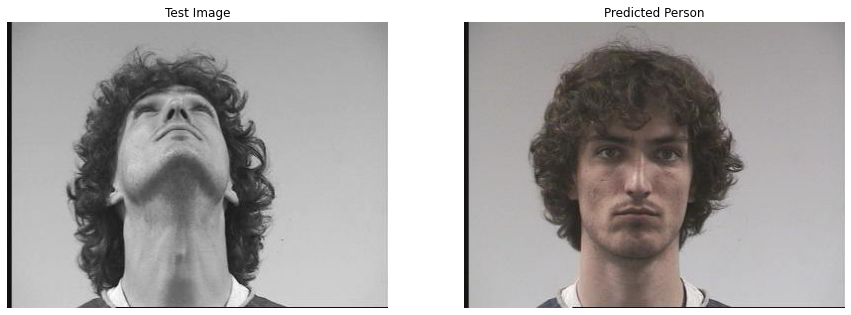

Person: 7
Pose: 92


In [5]:
test = io.imread("TestImages\\test8.jpg", as_gray=True)
findImage(test, pca_matrix, lda_matrix, lda_stacked)

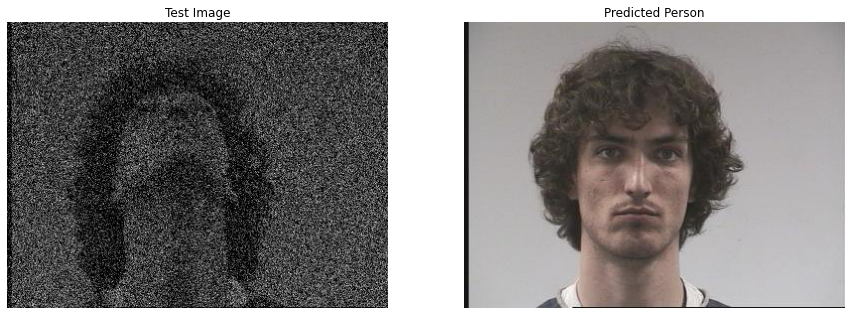

Person: 7
Pose: 92


In [6]:
out1 = test + np.random.normal(0, 0.5, test.shape)
out1 = np.clip(out1, 0, 255)
findImage(out1, pca_matrix, lda_matrix, lda_stacked)

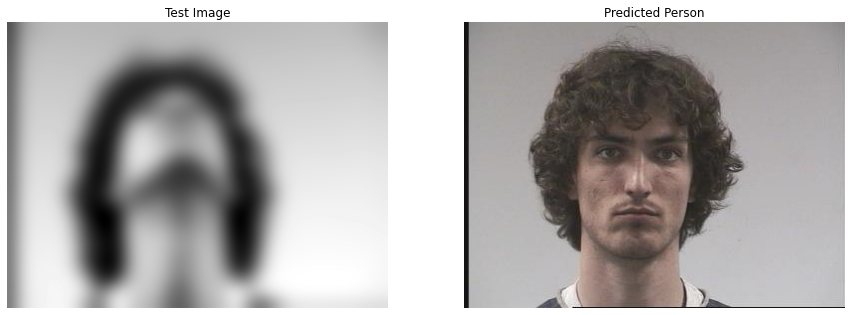

Person: 7
Pose: 92


In [7]:
out2 = gaussian_filter(test, 10)
findImage(out2, pca_matrix, lda_matrix, lda_stacked)

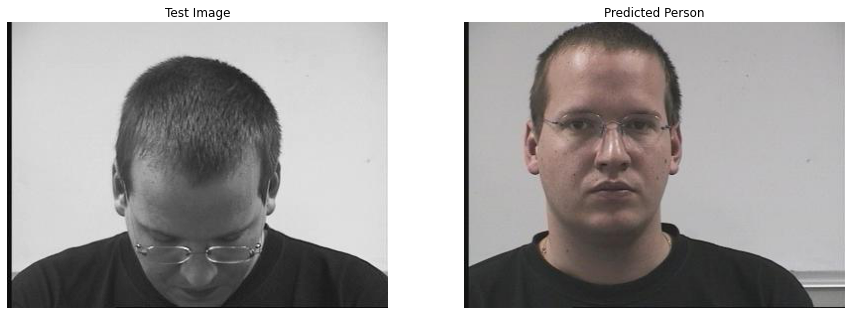

Person: 0
Pose: 0


In [8]:
test = io.imread("TestImages\\test1.jpg", as_gray=True)
findImage(test, pca_matrix, lda_matrix, lda_stacked)

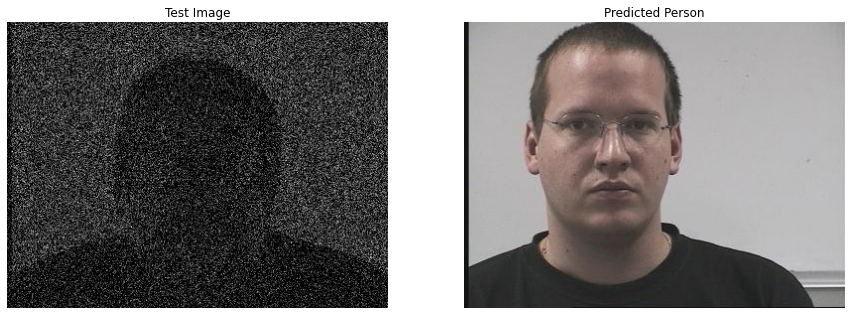

Person: 0
Pose: 0


In [9]:
out1 = test + np.random.normal(0, 0.8, test.shape)
out1 = np.clip(out1, 0, 255)
findImage(out1, pca_matrix, lda_matrix, lda_stacked)

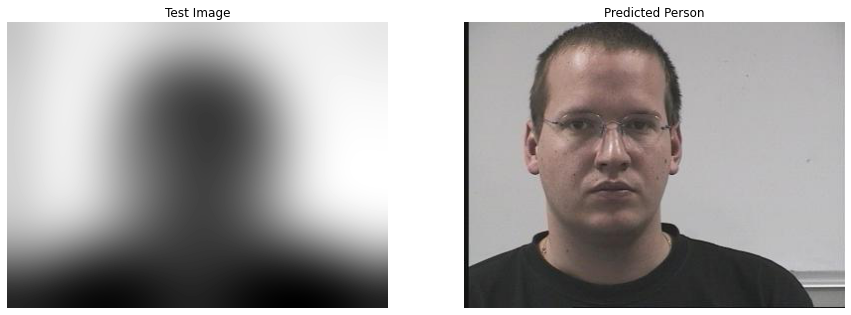

Person: 0
Pose: 0


In [10]:
out2 = gaussian_filter(test, 30)
findImage(out2, pca_matrix, lda_matrix, lda_stacked)